In [2]:
import pickle # Load pickled data
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

%matplotlib inline

---
## Step 0: Load The Data

In [58]:
training_file = './train.p'
validation_file='./valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

In [4]:
n_train = X_train.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:4]

n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


As first step, visualize some traffic sign

4


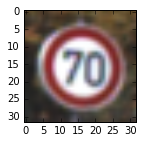

In [10]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
print(y_train[index])

And plot number of each traffic sign

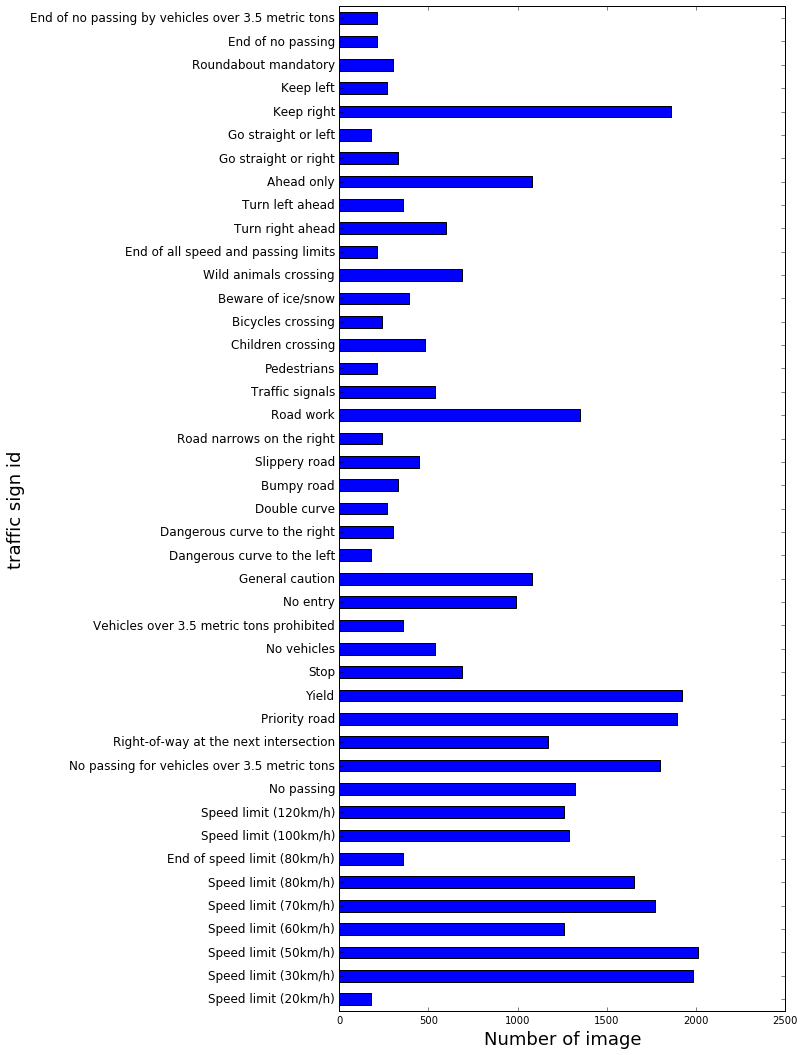

In [5]:
df_signname = pd.read_csv('signnames.csv')
df_y_train = pd.Series(y_train)
df_y_test = pd.Series(y_test)
ax = df_y_train.value_counts().sort_index().plot(kind='barh', figsize=(8,18))
#df_y_test.value_counts().sort_index().plot(kind='barh',stacked=True, ax=ax, color='green')
ax.set_yticklabels(df_signname['SignName'], fontsize=12)
ax.set_ylabel('traffic sign id', fontsize=18)
ax.set_xlabel('Number of image', fontsize=18)

----

## Step 2: Design and Test a Model Architecture

### 1. Pre-process the Data Set (augmentation, normalization, grayscale)

#### 1.1. Change Contrast

In [6]:
def Change_Contrast(min_table_, max_table_, LH, src):
    # Create Look Up Table
    min_table = min_table_
    max_table = max_table_
    diff_table = max_table - min_table

    LUT_HC = np.arange(256, dtype = 'uint8' )
    LUT_LC = np.arange(256, dtype = 'uint8' )

    if(LH==1):
        # Create High Contrast Look Up Table
        for i in range(0, min_table):
            LUT_HC[i] = 0
        for i in range(min_table, max_table):
            LUT_HC[i] = 255 * (i - min_table) / diff_table
        for i in range(max_table, 255):
            LUT_HC[i] = 255
        return cv2.LUT(src, LUT_HC)

    elif(LH==0):
        # Create Low Contrast Look Up Table
        for i in range(256):
            LUT_LC[i] = min_table + i * (diff_table) / 255

        return cv2.LUT(src, LUT_LC)

High contrast image should be created from bright image, but low contrast image with high max_table is useful from any image.
- ref (http://qiita.com/bohemian916/items/9630661cd5292240f8c7)

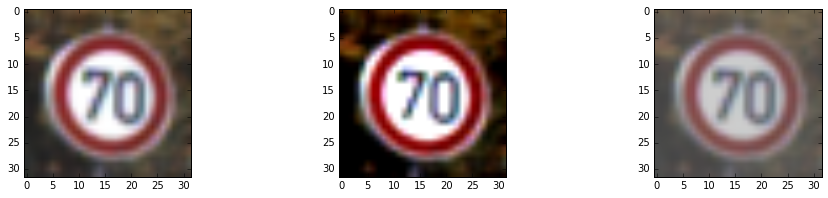

In [12]:
src = image
high_cont_img = Change_Contrast(50,205,1, src)
low_cont_img = Change_Contrast(50,205,0, src)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
ax1.imshow(src)
ax2.imshow(high_cont_img)
ax3.imshow(low_cont_img)

#### 1.2. Change Brightness

In [13]:
def Gamma_conversion(gamma_, src):
    # Create Look Up Table
    gamma = gamma_
    LUT_G = np.arange(256, dtype = 'uint8' )
    for i in range(256):
        LUT_G[i] = 255 * pow(float(i) / 255, 1.0 / gamma)

    return cv2.LUT(src, LUT_G)

Bright image is easier to predict, but to improve prediction of dark image, dark image should be augmented.

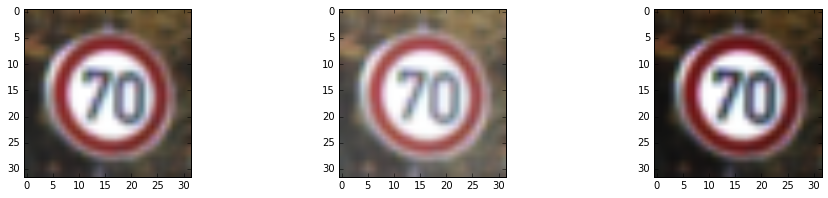

In [16]:
src = image
bright_img = Gamma_conversion(1.5, src)
dark_img = Gamma_conversion(0.75, src)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
ax1.imshow(src)
ax2.imshow(bright_img)
ax3.imshow(dark_img)

In [59]:
df_train_count = df_y_train.value_counts().sort_index()
max_count = df_train_count.max()

default = len(y_train)

for i_class in range(43):
    j = max_count - df_train_count[i_class]
    print('class', i_class)
    #print('required number =',j)
    for i_index in range(len(y_train)):
        if(y_train[i_index]==i_class):
            src = X_train[i_index]
            dark_img = Gamma_conversion(0.75, src).reshape([1, 32, 32, 3])
            X_train = np.concatenate([X_train, dark_img])
            y_train = np.concatenate([y_train, [i_class]])
print(len(y_train) - default, 'images are generated')

class 0
class 1
class 2
class 3
class 4
class 5
class 6
class 7
class 8
class 9
class 10
class 11
class 12
class 13
class 14
class 15
class 16
class 17
class 18
class 19
class 20
class 21
class 22
class 23
class 24
class 25
class 26
class 27
class 28
class 29
class 30
class 31
class 32
class 33
class 34
class 35
class 36
class 37
class 38
class 39
class 40
class 41
class 42
34799 images are generated


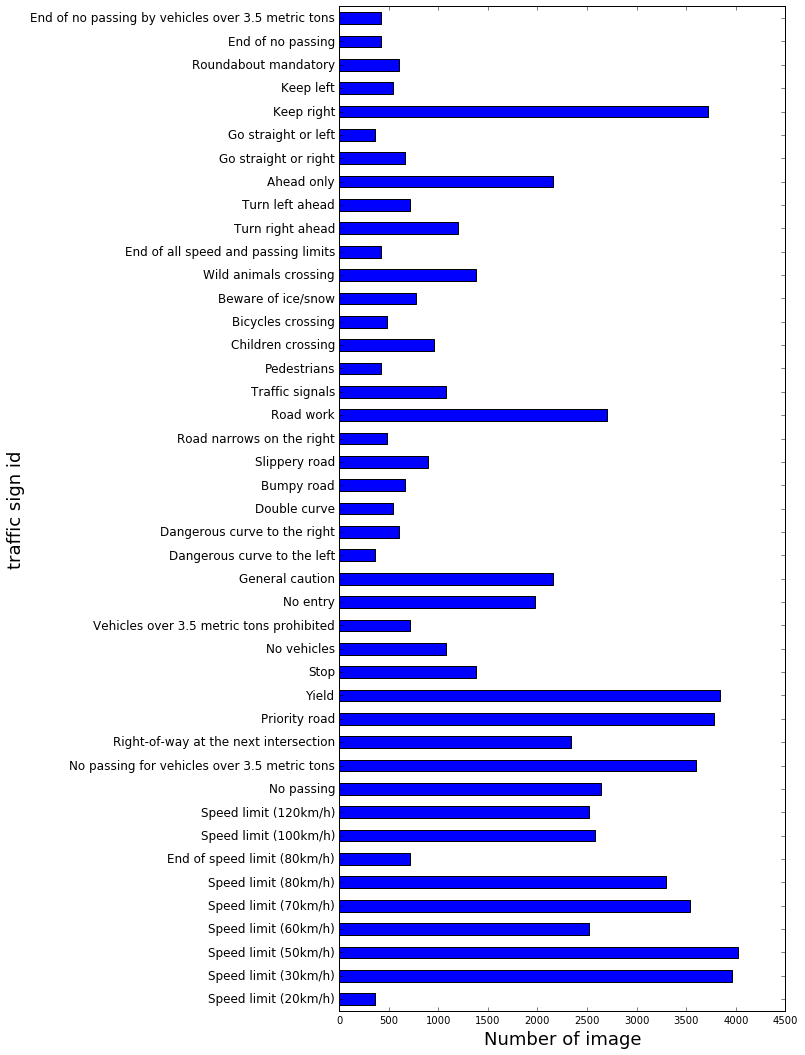

In [62]:
df_y_train = pd.Series(y_train)
ax = df_y_train.value_counts().sort_index().plot(kind='barh', figsize=(8,18))
ax.set_yticklabels(df_signname['SignName'], fontsize=12)
ax.set_ylabel('traffic sign id', fontsize=18)
ax.set_xlabel('Number of image', fontsize=18)
#len(y_train)

### Model Architecture

In [63]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [64]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [65]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [66]:
EPOCHS = 30
BATCH_SIZE = 128

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [67]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.743

EPOCH 2 ...
Validation Accuracy = 0.805

EPOCH 3 ...
Validation Accuracy = 0.835

EPOCH 4 ...
Validation Accuracy = 0.861

EPOCH 5 ...
Validation Accuracy = 0.846

EPOCH 6 ...
Validation Accuracy = 0.863

EPOCH 7 ...
Validation Accuracy = 0.870

EPOCH 8 ...
Validation Accuracy = 0.873

EPOCH 9 ...
Validation Accuracy = 0.892

EPOCH 10 ...
Validation Accuracy = 0.903

EPOCH 11 ...
Validation Accuracy = 0.908

EPOCH 12 ...
Validation Accuracy = 0.892

EPOCH 13 ...
Validation Accuracy = 0.901

EPOCH 14 ...
Validation Accuracy = 0.892

EPOCH 15 ...
Validation Accuracy = 0.902

EPOCH 16 ...
Validation Accuracy = 0.901

EPOCH 17 ...
Validation Accuracy = 0.909

EPOCH 18 ...
Validation Accuracy = 0.918

EPOCH 19 ...
Validation Accuracy = 0.906

EPOCH 20 ...
Validation Accuracy = 0.917

EPOCH 21 ...
Validation Accuracy = 0.918

EPOCH 22 ...
Validation Accuracy = 0.921

EPOCH 23 ...
Validation Accuracy = 0.888

EPOCH 24 ...
Validation Accura

In [68]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.917


---

## Step 3: Test a Model on New Images

### Load and Output the Images

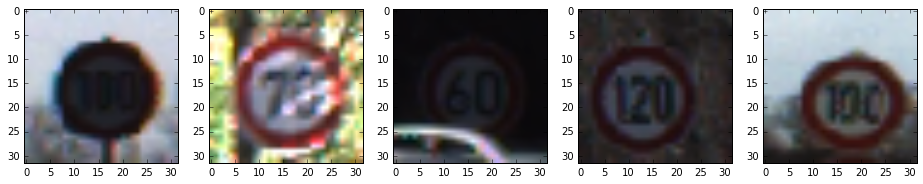

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,3))
list_id = [13,14,23,49,87]
i = 0
for ax in axes:
    image = Image.open('GTSRB/Final_Test/Images/000'+str(list_id[i])+'.ppm', 'r')
    resize_img = image.resize((32, 32))
    ax.imshow(np.array(resize_img))
    i += 1

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [70]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
i = 0
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred=tf.nn.softmax(logits)
    
    for i in range(5):
        image = Image.open('GTSRB/Final_Test/Images/000'+str(list_id[i])+'.ppm', 'r')
        resize_img = image.resize((32, 32))
        pred_prob = sess.run([pred],feed_dict={x:[np.array(resize_img)]})[0][0]
        print('Test Image '+str(i+1))
        for i in range(0, 43):
            if pred_prob[i] > 0.01:
                print( str(int(pred_prob[i]*100)) + '%: ' + '[' + str(df_signname['ClassId'][i]) + '] ' + str(df_signname['SignName'][i]) )
        print()

Test Image 1
30%: [2] Speed limit (50km/h)
59%: [7] Speed limit (100km/h)
10%: [8] Speed limit (120km/h)

Test Image 2
100%: [4] Speed limit (70km/h)

Test Image 3
99%: [23] Slippery road

Test Image 4
99%: [29] Bicycles crossing

Test Image 5
99%: [1] Speed limit (30km/h)



---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")